In [1]:
import pickle
import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
import keras.backend as K
import random

from keras.models import Sequential, load_model  
from keras.layers.core import Dense, Activation  
from keras.layers import LSTM, Flatten, Dropout
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, TimeDistributed, Flatten, Reshape, Conv2D, MaxPooling2D
from keras.models import Model
from keras.preprocessing import sequence
from keras.optimizers import Nadam
from keras import optimizers
from keras.layers.normalization import BatchNormalization

from keras.datasets import mnist

%matplotlib inline
datapath = 'data/VLA2/5dBsim/'



/Users/emmacreeves/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


['data/VLA2/5dBsim/x_train.p']
data/VLA2/5dBsim/x_train.p (8000, 16, 201, 2) (0, 16, 201, 2)
(8000, 16, 201, 2) (8000,) (2000, 16, 201, 2) (2000,) (2000, 16, 201, 2) (2000,)
0.5129908206474556
(16, 201, 2)


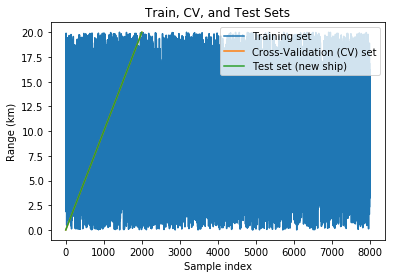

In [13]:
xtrains = sorted(glob.glob(datapath+'x_train.p')) #+ sorted(glob.glob(datapath+'x_train_VLA2_Mar25_Y*'))
print(xtrains)
ytrains = sorted(glob.glob(datapath+'y_train.p'))# + sorted(glob.glob(datapath+'y_train_VLA2_Mar25_Y*'))
xvals = sorted(glob.glob(datapath+'x_val.p')) #+ sorted(glob.glob(datapath+'x_test_VLA2_Mar25_Y*'))
yvals = sorted(glob.glob(datapath+'y_val.p'))# + sorted(glob.glob(datapath+'y_test_VLA2_Mar25_Y*'))

# intialize
Kinput = pickle.load(open(xtrains[0],'rb'))
X_training = np.empty([0,Kinput.shape[1],Kinput.shape[2],Kinput.shape[3]])
Y_training = np.empty([0,])
X_val = np.empty([0,Kinput.shape[1],Kinput.shape[2],Kinput.shape[3]])
Y_val = np.empty([0,])
X_test = pickle.load(open(datapath+'x_test.p','rb'))
Y_test = pickle.load(open(datapath+'y_test.p','rb'))

for fi in np.arange(0,len(xtrains)):
    X_training_un = pickle.load(open(xtrains[fi],'rb'))
    Y_training_un = pickle.load(open(ytrains[fi],'rb'))
    X_val_un = pickle.load(open(xvals[fi],'rb'))
    Y_val_un = pickle.load(open(yvals[fi],'rb'))
    print(xtrains[fi], X_training_un.shape, X_val_un.shape)

    X_training = np.concatenate((X_training, X_training_un), axis=0)
    Y_training = np.concatenate((Y_training, Y_training_un), axis=0)
    X_val = np.concatenate((X_val, X_val_un), axis=0)
    Y_val = np.concatenate((Y_val, Y_val_un), axis=0)

    
img_x, img_y = 16, 201

# reshaping data to 4 dimensions
#X_training = X_training.reshape(X_training.shape[0], img_x, img_y, 1)
#X_val = X_val.reshape(X_val.shape[0], img_x, img_y, 1)
#X_test = X_test.reshape(X_test.shape[0], img_x, img_y, 1)
input_shape = (img_x, img_y, 2)

# Centering and Normalizing data
mux = np.mean(X_training, axis=0)
tmux = np.mean(X_test,axis=0)
stdx = np.std(X_training, axis=0)
X_training = (X_training - mux)/stdx
X_val = (X_val - mux)/stdx
X_test = (X_test - mux)/stdx

X_val = X_test
Y_val = Y_test

traindata = list(zip(X_training, Y_training))
random.shuffle(traindata)
X_training, Y_training = zip(*traindata)
X_training = np.array(X_training)
Y_training = np.array(Y_training)


print(X_training.shape, Y_training.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)
plt.plot(Y_training,label='Training set')
plt.plot(Y_val,label='Cross-Validation (CV) set')
plt.ylabel('Range (km)')
plt.xlabel('Sample index')
plt.title('Train, CV, and Test Sets')
plt.plot(Y_test,label='Test set (new ship)')

plt.legend()

print(mux[0,1,1]-tmux[0,1,1])
print(mux.shape)

In [3]:
def get_model(input_shape=[16,51,1]):
    input_layer = Input(shape=(input_shape))
    
    
    hidden_layer1 = Conv2D(32, kernel_size=(5,35), strides=(1,1),activation='relu')(input_layer)
   # batch_norm1 = BatchNormalization( name = "batch_norm_1")(hidden_layer1)
    
    hidden_layer2 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(hidden_layer1)
    #batch_norm2 = BatchNormalization( name = "batch_norm_2")(hidden_layer2)
    
    hidden_layer3 = Conv2D(64, (5,5), activation='relu')(hidden_layer2)
    #batch_norm3 = BatchNormalization( name = "batch_norm_3")(hidden_layer3)
    
    hidden_layer4 = MaxPooling2D(pool_size=(2,2))(hidden_layer3)
   # batch_norm4 = BatchNormalization( name = "batch_norm_4")(hidden_layer4)

   # hidden_layer5 = Conv2D(128, (1,1), activation='relu')(batch_norm4)
    #batch_norm3 = BatchNormalization( name = "batch_norm_3")(hidden_layer3)
    
   # hidden_layer6 = MaxPooling2D(pool_size=(1,1))(hidden_layer5)
   # batch_norm4 = BatchNormalization( name = "batch_norm_4")(hidden_layer4)
    
    hidden_layer7 = Flatten()(hidden_layer4)
  #  batch_norm5 = BatchNormalization( name = "batch_norm_5")(hidden_layer5)
    
    hidden_layer8 = Dense(1024, activation="relu")(hidden_layer7)
   # batch_norm6 = BatchNormalization( name = "batch_norm_6")(hidden_layer6)  
    
    hidden_layer9 = Dense(256, activation="relu")(hidden_layer8)
    
    output_layer = Dense(1, activation="linear")(hidden_layer9)
    model = Model(inputs = input_layer, output = output_layer)
    
    return model
    
    

n_epochs = 25
optimizer = optimizers.RMSprop()#lr=1e-4)#, beta_1=0.9, beta_2=0.999, epsilon=1e-08)#, schedule_decay=0.004)
model = get_model(input_shape)
model.compile(loss="mean_squared_error", optimizer=optimizer)


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


/Users/emmacreeves/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [4]:

batch_size = 20
L=len(X_training)
val_data = (X_val, Y_val)
history = model.fit(X_training, Y_training, batch_size=batch_size, epochs=n_epochs, validation_data=val_data)

Train on 8000 samples, validate on 2000 samples
Epoch 1/25
8000/8000 [==============================] - 41s 5ms/step - loss: 32.0335 - val_loss: 101.6706
Epoch 2/25
8000/8000 [==============================] - 45s 6ms/step - loss: 9.5184 - val_loss: 110.5163
Epoch 3/25
8000/8000 [==============================] - 51s 6ms/step - loss: 6.0824 - val_loss: 65.8595
Epoch 4/25
8000/8000 [==============================] - 55s 7ms/step - loss: 4.1067 - val_loss: 63.2601
Epoch 5/25
8000/8000 [==============================] - 59s 7ms/step - loss: 3.0884 - val_loss: 51.4532
Epoch 6/25
8000/8000 [==============================] - 65s 8ms/step - loss: 2.5344 - val_loss: 40.0525
Epoch 7/25
8000/8000 [==============================] - 60s 8ms/step - loss: 2.0287 - val_loss: 35.2121
Epoch 8/25
8000/8000 [==============================] - 60s 7ms/step - loss: 1.7670 - val_loss: 25.4104
Epoch 9/25
8000/8000 [==============================] - 61s 8ms/step - loss: 1.6098 - val_loss: 28.6829
Epoch 10/25
8

TypeError: tuple indices must be integers or slices, not tuple

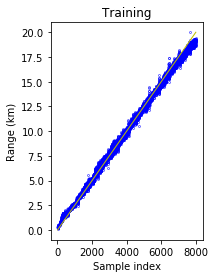

In [8]:
fig = plt.figure()

preds = model.predict(X_val)
preds2 = model.predict(X_training)
preds3 = model.predict(X_test)

_pred = list(zip(preds2, Y_training))
_pred.sort(key=lambda x: x[1])
preds2, Y_tr = zip(*_pred)

plt.subplot(121)
plt.plot(preds2,'o',color='blue',markersize=2,mew=0.5,mec='blue',markerfacecolor='none')
plt.plot(Y_tr,'y',linewidth=1.0)
#plt.legend(['Training Set', 'Ground Truth'])
plt.xlabel('Sample index')
plt.ylabel('Range (km)')
plt.title('Training')

RMSE_Ytrain = np.sqrt(np.mean(np.square(np.abs(Y_training-preds2[:,0]))))


plt.subplot(122)
plt.plot(preds,'o',color='blue',markersize=2,mew=0.5,mec='blue',markerfacecolor='none')
plt.plot(Y_val,'r',linewidth=1.0)
#plt.legend(['Predictions', 'Ground Truth'])
plt.xlabel('Sample index')
#plt.ylabel('Range (km)')
plt.title('Validation')

RMSE_Yval = np.sqrt(np.mean(np.square(np.abs(Y_val-preds[:,0]))))

#plt.subplot(133)
plt.figure()
plt.plot(preds3,'o',color='blue',markersize=2,mew=0.5,mec='blue',markerfacecolor='none')
plt.plot(Y_test,'r',linewidth=1.0)
#plt.plot(Y_training,'y',linewidth=1.0)
plt.legend(['Predictions', 'Ground Truth'])
plt.xlabel('Sample index')
#plt.ylabel('Range (km)')
plt.title('Test (Simulation)')
plt.savefig('test_CNN_simulation_5dB.pdf')
plt.show()


RMSE_Ytest = np.sqrt(np.mean(np.square(np.abs(Y_test-preds3[:,0]))))
MAE = np.mean(np.abs(Y_test - preds3[:,0])/Y_test)

print('Training set RMSE = ' + str(RMSE_Ytrain) + ' km')
print('Validation set RMSE = ' + str(RMSE_Yval) + ' km')
print('Test set RMSE = ' + str(RMSE_Ytest) + ' km')
print('Test mean relative error = ' + str(MAE) + ' km')

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.figure()
plt.plot(Y_test,np.abs(Y_test - preds3[:,0])/Y_test*100)